# Housekeeping (*installs and imports*)

Librarys

In [1]:
!nvidia-smi

Thu Dec 21 02:50:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%%capture
!pip install ktrain
!pip install transformers
!pip install wget
!git clone https://github.com/paulhimstedt/data_aug_irony

In [3]:
import wget
import ktrain
from ktrain import text
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score
import matplotlib.pyplot as plt
from collections import Counter

Parameters

In [4]:
GLOBAL_LEARNING_RATE = 10E-05
DATASET_NAME = "iSarcasm"
N_TRAINING_EPOCHS = 12
N_TRAINING_EPOCHS_AUGMENTED = 12
GLOBAL_BATCH_SIZE = 32
GLOBAL_MAXLEN = 128
GLOBAL_BERT_MODEL = "distilbert-base-cased"

To generate the entirety of the Results the following to parameter have to be set.

In [5]:
#TOP_N (range 0-4) accesses the individual percentages.
TOP_N =1 #
#current_split (range 1-5) selects the subsplin of training data
current_split = 3

## Evaluation method

The following cell calculates relevant metrics

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score
#Following def was advised by ChatGPT
def specificity_score(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

def evaluate_and_save_results(learner, distil_bert_preproc, eval_data_path, result_file_name):
    # Load your predictor
    predictor = ktrain.get_predictor(learner.model, preproc=distil_bert_preproc)
    print(predictor)
    # Load your evaluation data
    data_test = pd.read_csv(eval_data_path)
    test_intents = data_test["intent"].astype(str).values.tolist()
    test_utterances = data_test["utterance"].astype(str).values.tolist()

    # Make predictions
    predictions = predictor.predict(test_utterances)

    np_test_intents = np.array(test_intents)
    np_predictions = np.array(predictions)

    # Calculate Accuracy
    accuracy = accuracy_score(np_test_intents, np_predictions)
    accuracy_str = "Accuracy: {:.2f}%".format(accuracy * 100)
    print(accuracy_str)

    # Calculate Confusion Matrix
    conf_matrix = confusion_matrix(np_test_intents, np_predictions)

    # Calculate Log-loss
    predicted_probabilities = predictor.predict_proba(test_utterances)
    logloss = log_loss(np_test_intents, predicted_probabilities)
    logloss_str = "Log-loss: {:.4f}".format(logloss)
    print(logloss_str)

    # Calculate AUC-ROC
    roc_auc = roc_auc_score(np_test_intents, predicted_probabilities[:, 1])
    roc_auc_str = "AUC-ROC: {:.4f}".format(roc_auc)
    print(roc_auc_str)

    # Calculate Precision, Recall, F-Score, specificity
    precision = precision_score(np_test_intents, np_predictions, average='weighted')
    recall = recall_score(np_test_intents, np_predictions, average='weighted')
    f_score = f1_score(np_test_intents, np_predictions, average='weighted')
    specificity = specificity_score(np_test_intents, np_predictions)

    precision_str = "Precision: {:.4f}".format(precision)
    recall_str = "Recall: {:.4f}".format(recall)
    f_score_str = "F-Score: {:.4f}".format(f_score)
    specificity_str = "Specificity: {:.4f}".format(specificity)

    print(precision_str)
    print(recall_str)
    print(f_score_str)
    print(specificity_str)

    # Print other model params
    num_trainable_params = sum(np.prod(w.shape) for w in learner.model.trainable_variables)
    trainable_params_str = "Number of Trainable Parameters: {}".format(num_trainable_params)

    # Save results to a text file
    with open(result_file_name, 'w') as f:
        f.write(accuracy_str + "\n")
        f.write(logloss_str + "\n")
        f.write(roc_auc_str + "\n")
        f.write(precision_str + "\n")
        f.write(recall_str + "\n")
        f.write(f_score_str + "\n")
        f.write(specificity_str + "\n")
        f.write(trainable_params_str + "\n")

    # Plot and save cm
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(result_file_name.replace(".txt", "_confusion_matrix.png"))

## Load data

In [7]:
data_train = pd.read_csv(f'/content/data_aug_irony/data/k-fold-training-splits/split_{current_split}.csv')
X = data_train['utterance']
y = data_train['intent']

X_train = []
X_valid = []
y_train = []
y_valid = []

# Perform train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.tolist()
X_valid = X_valid.tolist()
y_train = y_train.tolist()
y_valid = y_valid.tolist()

X_train = [str(x) for x in X_train]
X_valid = [str(x) for x in X_valid]

In [8]:
print("Shape of X_train:", len(X_train))
print("Shape of X_valid:", len(X_valid))
print("Shape of y_train:", len(y_train))
print("Shape of y_valid:", len(y_valid))

Shape of X_train: 555
Shape of X_valid: 139
Shape of y_train: 555
Shape of y_valid: 139


## Utils

calculate weights

In [9]:
import pandas as pd

def calculate_class_weights(data_train):
    # Count the number of samples for each class
    minority_count = len(data_train[data_train['intent'] == "sarcastic"])
    majority_count = len(data_train[data_train['intent'] == "not sarcastic"])

    print(f"Minority Class Count: {minority_count}")
    print(f"Majority Class Count: {majority_count}")

    # Calculate class weights for adjusted sampling
    total_samples = minority_count + majority_count

    class_weight = {
        0: total_samples / (2 * majority_count),
        1: total_samples / (2 * minority_count)
    }
    print(class_weight)
    return class_weight

In [10]:
# Count the number of samples for each class
minority_count = len(data_train[data_train['intent'] == "sarcastic"])
majority_count = len(data_train[data_train['intent'] == "not sarcastic"])

print(f"Minority Class Count: {minority_count}")
print(f"Majority Class Count: {majority_count}")

Minority Class Count: 173
Majority Class Count: 521


In [11]:
# Calculate class weights for adjusted sampling

total_samples = minority_count + majority_count

class_weight = {
    0: total_samples / (2 * majority_count),
    1: total_samples / (2 * minority_count)
}
print(class_weight)

{0: 0.6660268714011516, 1: 2.005780346820809}


prepare augmentation ratios

This code was reworked by ChatGPT

In [12]:
split_size = minority_count + majority_count

percentage_split_list = [0.01, 0.05, 0.1, 0.25, 0.5, (majority_count - minority_count)/split_size]  # Example percentages

percent_names = ["percent_1", "percent_5", "percent_10", "percent_25", "percent_50", "percent_weighted"]

# Create a dictionary to store the values
percent_dict = {name: split_size * percentage for name, percentage in zip(percent_names, percentage_split_list)}

# Create a list with the calculated values
percent_of_augmentation = list(percent_dict.values())

# Access values by index
percent_1_value = percent_of_augmentation[TOP_N]
print(f"{percent_names[TOP_N]}: {percent_1_value}")

percent_5: 34.7


# Train baseline classifiers

## Train baseline classifier

### Initialize model and learner

In [13]:
distil_bert_baseline = text.Transformer(GLOBAL_BERT_MODEL, maxlen=GLOBAL_MAXLEN)

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

In [14]:
processed_train = distil_bert_baseline.preprocess_train(X_train, y_train)
processed_test = distil_bert_baseline.preprocess_test(X_valid, y_valid)

model_baseline = distil_bert_baseline.get_classifier()
learner_baseline = ktrain.get_learner(model_baseline, train_data=processed_train, val_data=processed_test, batch_size=GLOBAL_BATCH_SIZE)

preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 43
	99percentile : 52


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 19
	95percentile : 41
	99percentile : 47


### Train classifier

In [15]:
learner_baseline.fit_onecycle(GLOBAL_LEARNING_RATE, N_TRAINING_EPOCHS)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/12
18/18 [==============================] - 31s 556ms/step - loss: 0.6144 - accuracy: 0.7243 - val_loss: 0.5657 - val_accuracy: 0.7482
Epoch 2/12
18/18 [==============================] - 7s 404ms/step - loss: 0.5604 - accuracy: 0.7514 - val_loss: 0.5647 - val_accuracy: 0.7482
Epoch 3/12
18/18 [==============================] - 7s 412ms/step - loss: 0.5378 - accuracy: 0.7514 - val_loss: 0.5696 - val_accuracy: 0.7482
Epoch 4/12
18/18 [==============================] - 7s 411ms/step - loss: 0.3936 - accuracy: 0.8180 - val_loss: 0.8149 - val_accuracy: 0.5324
Epoch 5/12
18/18 [==============================] - 7s 416ms/step - loss: 0.2298 - accuracy: 0.9225 - val_loss: 1.0801 - val_accuracy: 0.7338
Epoch 6/12
18/18 [==============================] - 8s 424ms/step - loss: 0.1043 - accuracy: 0.9712 - val_loss: 1.1896 - val_accuracy: 0.6475
Epoch 7/12
18/18 [==============================] - 8s 425ms/step - loss: 0.0548 - 

In [16]:
predictor = ktrain.get_predictor(learner_baseline.model, preproc=distil_bert_baseline)

Evaluate

Accuracy: 73.07%
Log-loss: 1.0343
AUC-ROC: 0.5331
Precision: 0.7612
Recall: 0.7307
F-Score: 0.7450
Specificity: 0.8175


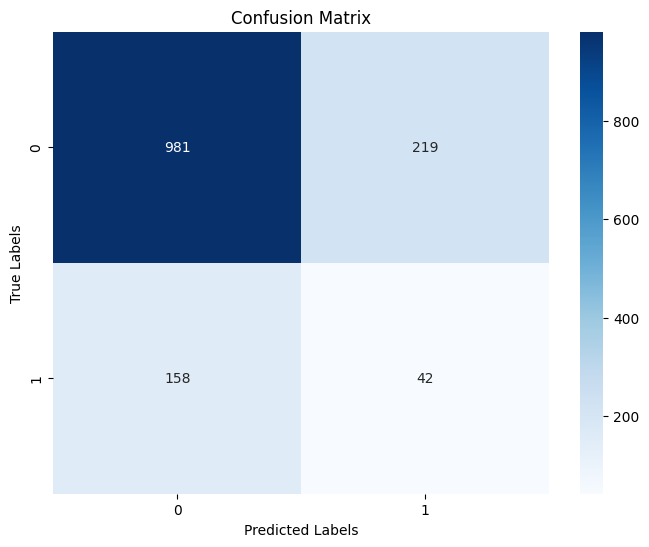

In [17]:
evaluate_and_save_results(learner_baseline, distil_bert_baseline, '/content/data_aug_irony/data/eval.csv', 'evaluation_results_baseline.txt')

## Train weighted baseline classifier

### Initialize model and learner

In [18]:
distil_bert_baseline_weighted = text.Transformer(GLOBAL_BERT_MODEL, maxlen=GLOBAL_MAXLEN)

In [19]:
processed_train = distil_bert_baseline_weighted.preprocess_train(X_train, y_train)
processed_test = distil_bert_baseline_weighted.preprocess_test(X_valid, y_valid)

model_baseline_weighted = distil_bert_baseline.get_classifier()
learner_baseline_weighted = ktrain.get_learner(model_baseline_weighted, train_data=processed_train, val_data=processed_test, batch_size=GLOBAL_BATCH_SIZE)

preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 43
	99percentile : 52


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 19
	95percentile : 41
	99percentile : 47


### Train classifier

In [20]:
learner_baseline_weighted.fit_onecycle(GLOBAL_LEARNING_RATE, N_TRAINING_EPOCHS,  class_weight=class_weight)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/12
18/18 [==============================] - 16s 501ms/step - loss: 0.6939 - accuracy: 0.6234 - val_loss: 0.7123 - val_accuracy: 0.2662
Epoch 2/12
18/18 [==============================] - 8s 425ms/step - loss: 0.6634 - accuracy: 0.5946 - val_loss: 0.6310 - val_accuracy: 0.5827
Epoch 3/12
18/18 [==============================] - 8s 421ms/step - loss: 0.5618 - accuracy: 0.6811 - val_loss: 0.7642 - val_accuracy: 0.3381
Epoch 4/12
18/18 [==============================] - 8s 419ms/step - loss: 0.4104 - accuracy: 0.8432 - val_loss: 1.3528 - val_accuracy: 0.4676
Epoch 5/12
18/18 [==============================] - 8s 419ms/step - loss: 0.1374 - accuracy: 0.9514 - val_loss: 1.2477 - val_accuracy: 0.5827
Epoch 6/12
18/18 [==============================] - 7s 415ms/step - loss: 0.0569 - accuracy: 0.9766 - val_loss: 1.3969 - val_accuracy: 0.7122
Epoch 7/12
18/18 [==============================] - 7s 415ms/step - loss: 0.0609 - 

Accuracy: 71.29%
Log-loss: 1.3152
AUC-ROC: 0.4989
Precision: 0.7566
Recall: 0.7129
F-Score: 0.7329
Specificity: 0.7967


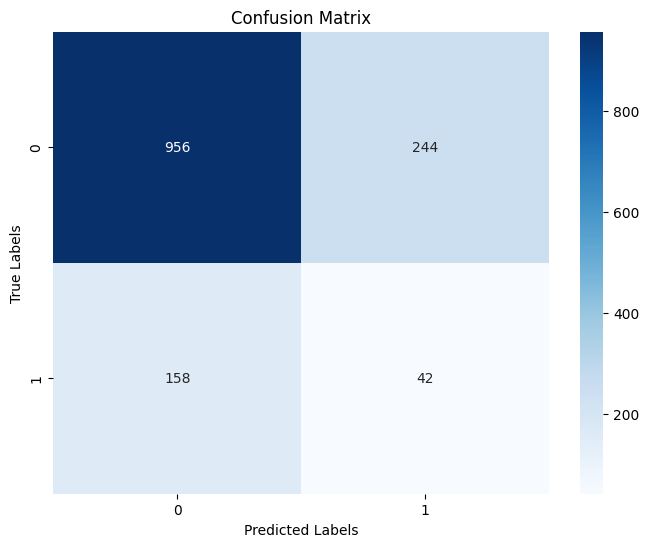

In [21]:
evaluate_and_save_results(learner_baseline_weighted, distil_bert_baseline_weighted, '/content/data_aug_irony/data/eval.csv', 'evaluation_results_baseline_weighted.txt')

# Train classifiers with augmented data

## Data preperations GPT2

The following 6 cells were adapted from the implementation by Steadforce. This is the filtering process described by anaby-tavor. It takes the entirety of generated instances and filters it using the baseline if the generated intent does match the predicted intent (https://www.steadforce.com/how-tos/lambada-method-how-to-use-data-augmentation-in-nlu)

In [22]:
augmented_data_gpt2 = pd.read_csv("/content/data_aug_irony/data/generated_data/gpt2/generated.csv")
augmented_data_gpt2 = augmented_data_gpt2.assign(utterance=[utterance.replace('!', '') for utterance in augmented_data_gpt2['utterance']])

In [23]:
def generate_predictions(predictor, generated_data):
    # Predict intents and probabilities
    predictions_for_generated = np.array(predictor.predict(generated_data['utterance'].tolist(), return_proba=False))
    proba_for_predictions_for_gen = predictor.predict(generated_data['utterance'].tolist(), return_proba=True)

    # Extract maximum probabilities for each prediction
    predicted_proba = np.array([max(probas) for probas in proba_for_predictions_for_gen])

    # Create a new DataFrame with the results
    generated_data_predicted = pd.DataFrame({
        "intent": generated_data['intent'],
        "utterance": generated_data['utterance'],
        "predicted_intent": predictions_for_generated,
        "prediction_proba": predicted_proba
    })

    return generated_data_predicted

In [24]:
def filter_generated_data(generated_data):
  correctly_predicted_data = generated_data[generated_data['intent'] == generated_data['predicted_intent']]
  print(f"Original length: {generated_data['utterance'].shape[0]} was shortened to {correctly_predicted_data['utterance'].shape[0]}")
  return correctly_predicted_data

In [25]:
predictor = ktrain.get_predictor(learner_baseline.model, preproc=distil_bert_baseline)

generated_data_predicted_gpt2 = generate_predictions(predictor, augmented_data_gpt2)
generated_data_predicted_gpt2.head()

,intent,utterance,predicted_intent,prediction_proba
0,sarcastic,I've seen people say that their last pizza was...,not sarcastic,0.994384
1,sarcastic,I dont understand how anyone can support the k...,not sarcastic,0.998493
2,sarcastic,Trying to stream My Little Pony: Friendship is...,not sarcastic,0.995112
3,sarcastic,i love it when the people at school ask me if ...,not sarcastic,0.983774
4,sarcastic,They said it would be a few days until we star...,not sarcastic,0.927920


In [26]:
gpt2_data = filter_generated_data(generated_data_predicted_gpt2)

Original length: 5700 was shortened to 1152


In [27]:
top_predictions_per_intent_gpt2 = gpt2_data.drop_duplicates(subset='utterance', keep='first').sort_values(by=['intent', 'prediction_proba'], ascending=[True, False]).drop_duplicates(keep='first').groupby('intent').head(percent_of_augmentation[TOP_N])

## Train classifier with augmented data from finetuned gpt2

### Concatate training data with augmented data

In [28]:
data_train_aug_gpt2 = pd.concat([pd.read_csv(f'/content/data_aug_irony/data/k-fold-training-splits/split_{current_split}.csv'),
                                top_predictions_per_intent_gpt2[['intent', 'utterance']]], ignore_index=True)

X_aug_gpt2 = data_train_aug_gpt2['utterance']
y_aug_gpt2 = data_train_aug_gpt2['intent']

X_train_aug_gpt2 = []
X_valid_aug_gpt2 = []
y_train_aug_gpt2 = []
y_valid_aug_gpt2 = []

# Perform train-test split
X_train_aug_gpt2, X_valid_aug_gpt2, y_train_aug_gpt2, y_valid_aug_gpt2 = train_test_split(X_aug_gpt2, y_aug_gpt2, test_size=0.2, stratify=y_aug_gpt2)

X_train_aug_gpt2 = X_train_aug_gpt2.tolist()
X_valid_aug_gpt2 = X_valid_aug_gpt2.tolist()
y_train_aug_gpt2 = y_train_aug_gpt2.tolist()
y_valid_aug_gpt2 = y_valid_aug_gpt2.tolist()

X_train_aug_gpt2 = [str(x) for x in X_train_aug_gpt2]
X_valid_aug_gpt2 = [str(x) for x in X_valid_aug_gpt2]

### Initialise augmented model and learner

In [29]:
distil_bert_augmented_gpt2 = text.Transformer(GLOBAL_BERT_MODEL, maxlen=GLOBAL_MAXLEN)

In [30]:
processed_train_aug_gpt2 = distil_bert_augmented_gpt2.preprocess_train(X_train_aug_gpt2, y_train_aug_gpt2)
processed_test_aug_gpt2 = distil_bert_augmented_gpt2.preprocess_test(X_valid_aug_gpt2, y_valid_aug_gpt2)

preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 43
	99percentile : 49


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 19
	95percentile : 46
	99percentile : 55


In [31]:
model_aug_gpt2 = distil_bert_augmented_gpt2.get_classifier()
learner_aug_gpt2 = ktrain.get_learner(model_aug_gpt2, train_data=processed_train_aug_gpt2, val_data=processed_test_aug_gpt2, batch_size=GLOBAL_BATCH_SIZE)

### Train classifier

In [32]:
learner_aug_gpt2.fit_onecycle(GLOBAL_LEARNING_RATE, N_TRAINING_EPOCHS_AUGMENTED)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/12
19/19 [==============================] - 19s 555ms/step - loss: 0.6405 - accuracy: 0.6209 - val_loss: 0.5949 - val_accuracy: 0.7123
Epoch 2/12
19/19 [==============================] - 8s 412ms/step - loss: 0.5746 - accuracy: 0.7136 - val_loss: 0.5424 - val_accuracy: 0.7671
Epoch 3/12
19/19 [==============================] - 8s 419ms/step - loss: 0.4244 - accuracy: 0.8199 - val_loss: 0.5707 - val_accuracy: 0.7397
Epoch 4/12
19/19 [==============================] - 9s 458ms/step - loss: 0.2474 - accuracy: 0.9245 - val_loss: 0.5611 - val_accuracy: 0.7192
Epoch 5/12
19/19 [==============================] - 8s 420ms/step - loss: 0.1545 - accuracy: 0.9605 - val_loss: 0.9740 - val_accuracy: 0.7534
Epoch 6/12
19/19 [==============================] - 8s 419ms/step - loss: 0.0630 - accuracy: 0.9811 - val_loss: 1.6189 - val_accuracy: 0.6233
Epoch 7/12
19/19 [==============================] - 9s 452ms/step - loss: 0.1406 - 

Accuracy: 75.79%
Log-loss: 1.3254
AUC-ROC: 0.5279
Precision: 0.7604
Recall: 0.7579
F-Score: 0.7591
Specificity: 0.8567


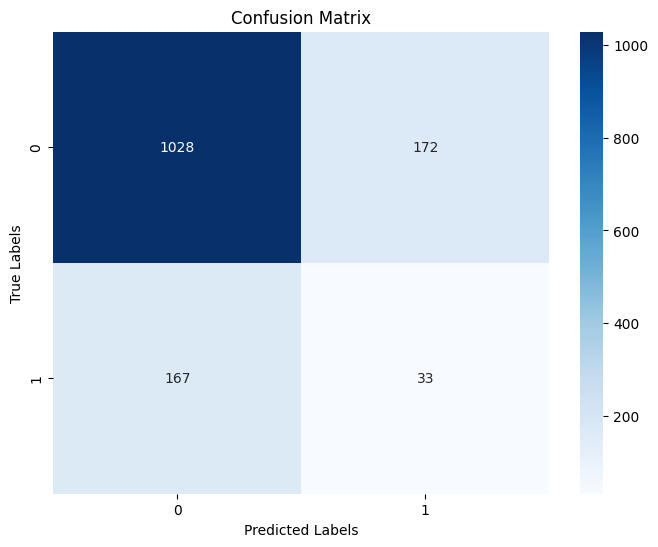

In [33]:
evaluate_and_save_results(learner_aug_gpt2, distil_bert_augmented_gpt2, '/content/data_aug_irony/data/eval.csv', f'evaluation_results_augmented_gpt2_{percent_names[TOP_N]}.txt')

## Data preperations GPT3

In [34]:
augmented_data_gpt3 = pd.read_csv("/content/data_aug_irony/data/generated_data/gpt3/generated.csv")

In [35]:
predictor = ktrain.get_predictor(learner_baseline.model, preproc=distil_bert_baseline)

generated_data_predicted_gpt3 = generate_predictions(predictor, augmented_data_gpt3)
generated_data_predicted_gpt3.head()

,intent,utterance,predicted_intent,prediction_proba
0,sarcastic,oh i just love having to apply to 60+ companie...,not sarcastic,0.995496
1,sarcastic,Oh no I’m a plastic bag very fucking hilarious,not sarcastic,0.998708
2,sarcastic,Oh joy;; crazy tutu and tiara drive-through la...,not sarcastic,0.998498
3,sarcastic,"And on day 1 after a short break, Laura almost...",sarcastic,0.983850
4,sarcastic,Giroud linking to make it 2-0 to ouz-lutons in...,not sarcastic,0.946255


In [36]:
gpt3_data = filter_generated_data(generated_data_predicted_gpt3)

Original length: 5400 was shortened to 956


In [37]:
top_predictions_per_intent_gpt3 = gpt3_data.drop_duplicates(subset='utterance', keep='first').sort_values(by=['intent', 'prediction_proba'], ascending=[True, False]).drop_duplicates(keep='first').groupby('intent').head(percent_of_augmentation[TOP_N])

## Train classifier with augmented data from finetuned gpt3

### Concatate training data with augmented data

In [40]:
data_train_aug_gpt3 = pd.concat([pd.read_csv(f'/content/data_aug_irony/data/k-fold-training-splits/split_{current_split}.csv'),
                                top_predictions_per_intent_gpt3[['intent', 'utterance']]], ignore_index=True)
X_aug_gpt3 = data_train_aug_gpt3['utterance']
y_aug_gpt3 = data_train_aug_gpt3['intent']

X_train_aug_gpt3 = []
X_valid_aug_gpt3 = []
y_train_aug_gpt3 = []
y_valid_aug_gpt3 = []

# Perform train-test split
X_train_aug_gpt3, X_valid_aug_gpt3, y_train_aug_gpt3, y_valid_aug_gpt3 = train_test_split(X_aug_gpt3, y_aug_gpt3, test_size=0.2,  stratify=y_aug_gpt3)

X_train_aug_gpt3 = X_train_aug_gpt3.tolist()
X_valid_aug_gpt3 = X_valid_aug_gpt3.tolist()
y_train_aug_gpt3 = y_train_aug_gpt3.tolist()
y_valid_aug_gpt3 = y_valid_aug_gpt3.tolist()

X_train_aug_gpt3 = [str(x) for x in X_train_aug_gpt3]
X_valid_aug_gpt3 = [str(x) for x in X_valid_aug_gpt3]

### Initialise augmented model and learner

In [41]:
distil_bert_augmented_gpt3 = text.Transformer(GLOBAL_BERT_MODEL, maxlen=GLOBAL_MAXLEN)

In [42]:
processed_train_aug_gpt3 = distil_bert_augmented_gpt3.preprocess_train(X_train_aug_gpt3, y_train_aug_gpt3)
processed_test_aug_gpt3 = distil_bert_augmented_gpt3.preprocess_test(X_valid_aug_gpt3, y_valid_aug_gpt3)

preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 43
	99percentile : 49


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 20
	95percentile : 46
	99percentile : 53


In [43]:
model_aug_gpt3 = distil_bert_augmented_gpt3.get_classifier()
learner_aug_gpt3 = ktrain.get_learner(model_aug_gpt3, train_data=processed_train_aug_gpt3, val_data=processed_test_aug_gpt3, batch_size=GLOBAL_BATCH_SIZE)

### Train classifier

In [44]:
learner_aug_gpt3.fit_onecycle(GLOBAL_LEARNING_RATE, N_TRAINING_EPOCHS_AUGMENTED)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/12
19/19 [==============================] - 20s 496ms/step - loss: 0.6277 - accuracy: 0.7067 - val_loss: 0.6493 - val_accuracy: 0.7123
Epoch 2/12
19/19 [==============================] - 8s 415ms/step - loss: 0.6102 - accuracy: 0.7153 - val_loss: 0.6005 - val_accuracy: 0.7123
Epoch 3/12
19/19 [==============================] - 8s 417ms/step - loss: 0.5771 - accuracy: 0.7136 - val_loss: 0.5676 - val_accuracy: 0.6986
Epoch 4/12
19/19 [==============================] - 8s 417ms/step - loss: 0.4126 - accuracy: 0.8096 - val_loss: 0.6656 - val_accuracy: 0.6370
Epoch 5/12
19/19 [==============================] - 8s 418ms/step - loss: 0.2159 - accuracy: 0.9365 - val_loss: 0.9566 - val_accuracy: 0.7192
Epoch 6/12
19/19 [==============================] - 8s 409ms/step - loss: 0.2337 - accuracy: 0.9194 - val_loss: 0.6063 - val_accuracy: 0.6918
Epoch 7/12
19/19 [==============================] - 8s 412ms/step - loss: 0.1598 - 

Accuracy: 67.14%
Log-loss: 1.6429
AUC-ROC: 0.5340
Precision: 0.7690
Recall: 0.6714
F-Score: 0.7108
Specificity: 0.7267


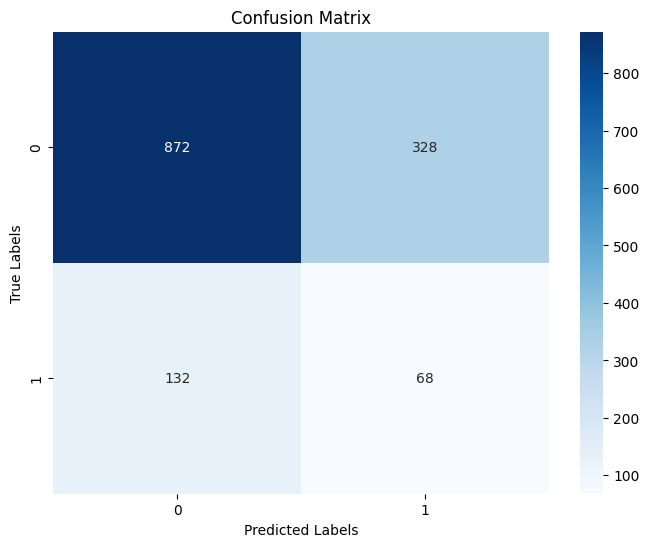

In [45]:
evaluate_and_save_results(learner_aug_gpt3, distil_bert_augmented_gpt3, '/content/data_aug_irony/data/eval.csv', f'evaluation_results_augmented_gpt3_{percent_names[TOP_N]}.txt')

## Train classifier with augmented data from finetuned gpt2 and gpt3 combined

### Concatate training data with augmented data

In [46]:
top_predictions_per_intent_gpt3_mixed = gpt3_data.drop_duplicates(subset='utterance', keep='first').sort_values(by=['intent', 'prediction_proba'], ascending=[True, False]).drop_duplicates(keep='first').groupby('intent').head(int(percent_of_augmentation[TOP_N]/2))
top_predictions_per_intent_gpt2_mixed = gpt2_data.drop_duplicates(subset='utterance', keep='first').sort_values(by=['intent', 'prediction_proba'], ascending=[True, False]).drop_duplicates(keep='first').groupby('intent').head(int(percent_of_augmentation[TOP_N]/2))

In [47]:
data_train_aug_gpt_mixed = pd.concat([pd.read_csv(f'/content/data_aug_irony/data/k-fold-training-splits/split_{current_split}.csv'),
                                      top_predictions_per_intent_gpt2_mixed[['intent', 'utterance']]], ignore_index=True)

data_train_aug_gpt_mixed = pd.concat([data_train_aug_gpt_mixed,
                                      top_predictions_per_intent_gpt3_mixed[['intent', 'utterance']]], ignore_index=True)

X_aug_gpt_mixed = data_train_aug_gpt_mixed['utterance']
y_aug_gpt_mixed = data_train_aug_gpt_mixed['intent']

X_train_aug_gpt_mixed = []
X_valid_aug_gpt_mixed = []
y_train_aug_gpt_mixed = []
y_valid_aug_gpt_mixed = []

# Perform train-test split
X_train_aug_gpt_mixed, X_valid_aug_gpt_mixed, y_train_aug_gpt_mixed, y_valid_aug_gpt_mixed = train_test_split(X_aug_gpt_mixed, y_aug_gpt_mixed, test_size=0.2, stratify=y_aug_gpt_mixed)

X_train_aug_gpt_mixed = X_train_aug_gpt_mixed.tolist()
X_valid_aug_gpt_mixed = X_valid_aug_gpt_mixed.tolist()
y_train_aug_gpt_mixed = y_train_aug_gpt_mixed.tolist()
y_valid_aug_gpt_mixed = y_valid_aug_gpt_mixed.tolist()

X_train_aug_gpt_mixed = [str(x) for x in X_train_aug_gpt_mixed]
X_valid_aug_gpt_mixed = [str(x) for x in X_valid_aug_gpt_mixed]

In [48]:
top_predictions_per_intent_gpt2_mixed[['intent', 'utterance']]

,intent,utterance
5515,sarcastic,Does anyone else feel a little uncomfortable o...
4835,sarcastic,love watching celebrities being sarcastic and ...
4146,sarcastic,There's nothing quite like seeing #CRS_Passeng...
2069,sarcastic,I’m leaving the gym for one hour and three min...
1700,sarcastic,How a quiet day at the office caused me to be ...
1282,sarcastic,"It’s not just me, it’s now the norm to acciden..."
2094,sarcastic,@mhampshirestewarti @jfoe Thanks for the remin...
3157,sarcastic,wish im sry but doing my exam in the morning a...
2458,sarcastic,💙 how's covid doing on #HBO 💙?
4660,sarcastic,@AishwariSarcastic A comment on the reason for...


In [49]:
top_predictions_per_intent_gpt3_mixed[['intent', 'utterance']]

,intent,utterance
4759,sarcastic,Having the worst #anxiety day I've had in a wh...
1390,sarcastic,Nothing like listening to an entire redneck fa...
3573,sarcastic,having to go to my CRNA clinical like some sor...
2175,sarcastic,Trying to limit taking my phone to the toilet ...
1243,sarcastic,Breaking news: I almost didn’t make it back to...
2884,sarcastic,Thanks @Apple for destroying my phone entire d...
3902,sarcastic,@BuenaVistaYeast 🍧 is *too* cool for ❄️. #Unpo...
5093,sarcastic,"Been in uni for eleven days, just ate a proper..."
2763,sarcastic,the internet outrage committee is too much at ...
2593,sarcastic,Love it when you book a day off to have a day ...


### Initialise augmented model and learner

In [50]:
distil_bert_augmented_gpt_mixed = text.Transformer(GLOBAL_BERT_MODEL, maxlen=GLOBAL_MAXLEN)

In [51]:
processed_train_aug_gpt_mixed = distil_bert_augmented_gpt_mixed.preprocess_train(X_train_aug_gpt_mixed, y_train_aug_gpt_mixed)
processed_test_aug_gpt_mixed = distil_bert_augmented_gpt_mixed.preprocess_test(X_valid_aug_gpt_mixed, y_valid_aug_gpt_mixed)

preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 43
	99percentile : 50


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 20
	95percentile : 43
	99percentile : 52


In [52]:
model_aug_gpt_mixed = distil_bert_augmented_gpt_mixed.get_classifier()
learner_aug_gpt_mixed = ktrain.get_learner(model_aug_gpt_mixed, train_data=processed_train_aug_gpt_mixed, val_data=processed_test_aug_gpt_mixed, batch_size=GLOBAL_BATCH_SIZE)

### Train classifier

In [53]:
learner_aug_gpt_mixed.fit_onecycle(GLOBAL_LEARNING_RATE, N_TRAINING_EPOCHS_AUGMENTED)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/12
19/19 [==============================] - 18s 531ms/step - loss: 0.6270 - accuracy: 0.6821 - val_loss: 0.6160 - val_accuracy: 0.7123
Epoch 2/12
19/19 [==============================] - 8s 419ms/step - loss: 0.5912 - accuracy: 0.7285 - val_loss: 0.6168 - val_accuracy: 0.7123
Epoch 3/12
19/19 [==============================] - 8s 421ms/step - loss: 0.5960 - accuracy: 0.7062 - val_loss: 0.5785 - val_accuracy: 0.7123
Epoch 4/12
19/19 [==============================] - 8s 420ms/step - loss: 0.4962 - accuracy: 0.7577 - val_loss: 0.9294 - val_accuracy: 0.2877
Epoch 5/12
19/19 [==============================] - 8s 413ms/step - loss: 0.4684 - accuracy: 0.8041 - val_loss: 0.8522 - val_accuracy: 0.6849
Epoch 6/12
19/19 [==============================] - 8s 414ms/step - loss: 0.4066 - accuracy: 0.8419 - val_loss: 0.6928 - val_accuracy: 0.7192
Epoch 7/12
19/19 [==============================] - 8s 409ms/step - loss: 0.3380 - 

Accuracy: 82.79%
Log-loss: 0.5856
AUC-ROC: 0.5951
Precision: 0.7998
Recall: 0.8279
F-Score: 0.8112
Specificity: 0.9300


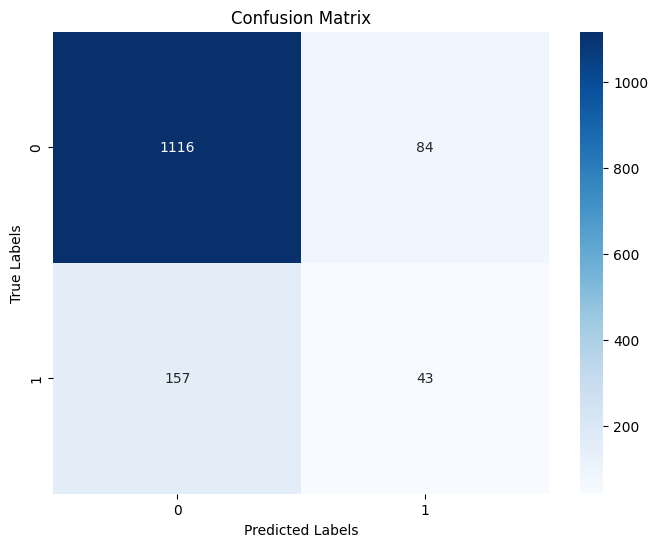

In [54]:
evaluate_and_save_results(learner_aug_gpt_mixed, distil_bert_augmented_gpt_mixed, '/content/data_aug_irony/data/eval.csv', f'evaluation_results_augmented_gpt_mixed_{percent_names[TOP_N]}.txt')

# download all files from session

Util provided by ChatGPT

In [55]:
import os
import shutil
from zipfile import ZipFile
from google.colab import files

def zip_and_download_files():
    # Create a new folder to store the files
    folder_name = 'result_files_test'
    os.makedirs(folder_name, exist_ok=True)

    # Get all files starting with 'evaluation' in the current directory
    files_to_copy = [file for file in os.listdir() if file.startswith('evaluation')]

    # Copy files to the new folder
    for file in files_to_copy:
        src_path = file
        dst_path = os.path.join(folder_name, file)
        shutil.copy2(src_path, dst_path)

    # Zip the folder
    zip_file_path = shutil.make_archive(folder_name, 'zip', folder_name)

    # Download the zip file
    files.download(zip_file_path)

# Call the function to execute the task
zip_and_download_files()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>